# Instantiate BERT model

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 21 15:30:22 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.78                 Driver Version: 551.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 5000              WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   54C    P8             18W /   50W |     787MiB /  16384MiB |     16%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
# BERT reference: https://www.kaggle.com/models/tensorflow/bert
# !pip install tensorflow_hub tensorflow_text -> run if needed
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [3]:
# Instatiate bert preprocessor
bert_preprocessor = hub.KerasLayer(preprocess_url)

# Preprocess the Text

In [4]:
# Create text
test_text = ['Hello, nice to meet you', 'What are you doing?']

# Preprocess the text
preprocessed_text = bert_preprocessor(test_text)

# Keys returned from the preprocessed text
print(preprocessed_text.keys())

dict_keys(['input_type_ids', 'input_word_ids', 'input_mask'])


In [5]:
# Shows the word ids for each word
print(preprocessed_text['input_word_ids'])

tf.Tensor(
[[ 101 7592 1010 3835 2000 3113 2017  102    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 101 2054 2024 2017 2725 1029  102    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    

# Convert the text into its word embeddings

In [6]:
# Instatiate the Bert encoder to get the word embeddings
bert_model = hub.KerasLayer(encoder_url)

# Get the word embeddings from text defined earlier
word_embeddings = bert_model(preprocessed_text)

# View the word embeddings' keys
print(word_embeddings.keys())

dict_keys(['encoder_outputs', 'sequence_output', 'pooled_output', 'default'])


In [7]:
# Show the embeddings for both scentences in the text
word_embeddings['pooled_output']

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.81530607, -0.35409263, -0.69899064, ..., -0.5374823 ,
        -0.6587062 ,  0.8210166 ],
       [-0.9474851 , -0.4375451 , -0.942899  , ..., -0.7329442 ,
        -0.7414421 ,  0.96138775]], dtype=float32)>

# Now that the sentences have been coverted to embeddings, it can be used in a neural network for different applications



Once we Have our political sentiment data, we can recreate the steps below in order to train our model.

For now, I tested it on a dataset for spam emails. This will be a simple neural network with a final softmax layer and an output of 2 for binary classification. When we are working with our political sentiment analysis data, we would need more (left leaning, right leaning, etc..)

# Process Data

In [8]:
# Read in file
data = pd.read_csv('spam.csv', encoding='latin1')

# Show some data
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


<AxesSubplot:>

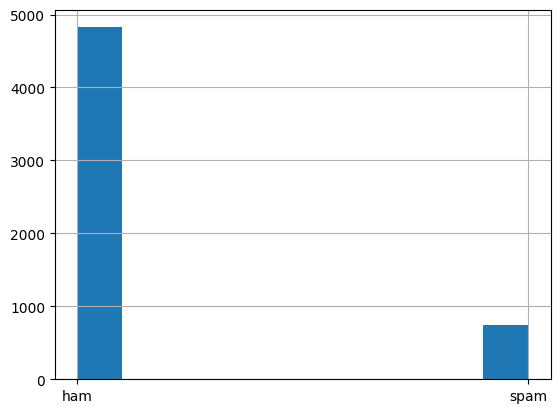

In [9]:
# Show data Imbalance
data['v1'].hist()

In [10]:
# Seperate only spam data
data_spam = data[data['v1'] == 'spam']
data_spam.shape

(747, 5)

In [11]:
# Seperate only non-spam data
data_ham = data[data['v1'] == 'ham']
data_ham.shape

(4825, 5)

In [12]:
# Down sample non-spam data to avoid overfitting
data_ham_downsampled = data_ham.sample(data_spam.shape[0])
data_ham_downsampled.shape

(747, 5)

In [13]:
# Merge samples backtogether again
final_data = pd.concat([data_spam, data_ham_downsampled])
final_data.shape

(1494, 5)

spam    747
ham     747
Name: v1, dtype: int64


<AxesSubplot:>

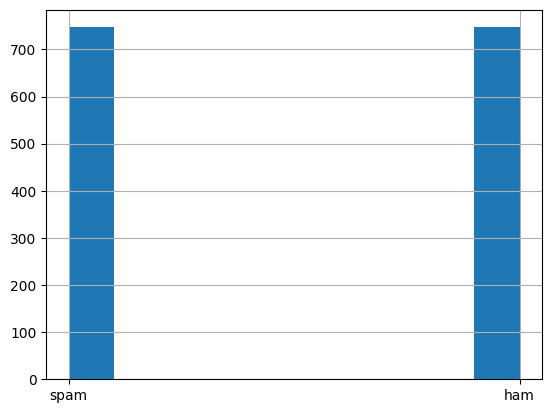

In [14]:
# Check downsampled dataset
print(final_data['v1'].value_counts())
final_data['v1'].hist()

In [15]:
print('Shape of final data: ' + str(final_data.shape))
final_data.sample(5)

Shape of final data: (1494, 5)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
3149,ham,Yo! Howz u? girls never rang after india. L,NaN,NaN,NaN
4293,spam,Kit Strip - you have been billed 150p. Netcoll...,NaN,NaN,NaN
5229,ham,It means u could not keep ur words.,NaN,NaN,NaN
4152,spam,URGENT!! Your 4* Costa Del Sol Holiday or å£50...,NaN,NaN,NaN
720,ham,Oh is it? Send me the address,NaN,NaN,NaN


In [16]:
# Convert spam and ham to 1s and 0s and store it in a new column named spam
final_data['spam'] = final_data['v1'].apply(lambda x: 1 if x=='spam' else 0)
final_data.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,spam
4784,spam,Urgent -call 09066649731from Landline. Your co...,NaN,NaN,NaN,1
2648,ham,"Hi, can i please get a &lt;#&gt; dollar loan...",NaN,NaN,NaN,0
1632,ham,Hello my little party animal! I just thought I...,NaN,NaN,NaN,0
3130,spam,LookAtMe!: Thanks for your purchase of a video...,NaN,NaN,NaN,1
5427,spam,Santa Calling! Would your little ones like a c...,NaN,NaN,NaN,1


# Get word embeddings for data

In [17]:
# Make training and testing split with data
X_train, X_test, y_train, y_test = train_test_split(final_data.drop(['v1', 'spam', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 2'], axis=1),
                                                    final_data['spam'],
                                                    stratify=final_data['spam'])

# final_data.drop(['v1', 'spam', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 2'], axis=1 takes in only v2 column

In [18]:
X_train.sample(10)

,v2
4478,Erutupalam thandiyachu
3495,Happy birthday... May u find ur prince charmin...
3418,Do you want a new Video phone? 600 anytime any...
4633,These won't do. Have to move on to morphine
4102,U have a secret admirer who is looking 2 make ...
5467,Get your garden ready for summer with a FREE s...
4515,Congrats! 2 mobile 3G Videophones R yours. cal...
2660,Want to finally have lunch today?
3988,Ok lor. Anyway i thk we cant get tickets now c...
1264,I will see in half an hour


In [19]:
# Defines a function to get the scentence embeddings for each entry
def get_sentence_embedding(sentences):
  # preprocess words
  preprocessed_text = bert_preprocessor(sentences)

  # get embedding vectors from the pooled_output key
  return bert_model(preprocessed_text)['pooled_output']

# Small scale driver to test function
get_sentence_embedding([
    'WINNER! As a valued network customer you hvae',
    'Kit Strip - you have been billed 150p'
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8806523 , -0.3831083 , -0.62446606, ..., -0.42110583,
        -0.62964034,  0.8747804 ],
       [-0.5140882 , -0.39360225, -0.8936088 , ..., -0.7950725 ,
        -0.4616834 ,  0.63142467]], dtype=float32)>

In [45]:
# Visualize getting embeddings for entire training set
X_train_embeddings = get_sentence_embedding(X_train['v2'])

# Get embeddings for testing set
X_test_embeddings = get_sentence_embedding(X_test['v2'])

In [46]:
# Before and after word embeddings
print('Before' + str(X_train.shape))
print('After' + str(X_train_embeddings.shape))

Before(1120, 1)
After(1120, 768)


In [21]:
# Convert the y vectors for the softmax function
y_train_one_hot = to_categorical(y_train, num_classes=2)
y_test_one_hot = to_categorical(y_test, num_classes=2)

# Create Neural Network


In [33]:
# Bert Layers for preprocessing and getting word embeddings
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocessor(text_input)
outputs = bert_model(preprocessed_text)

# Neural network layers
hiddenLayer = tf.keras.layers.Dense(50, name='hidden', activation='relu')(outputs['pooled_output'])
dropoutLayer = tf.keras.layers.Dropout(0.1, name='drouput')(hiddenLayer)
outputLayer = tf.keras.layers.Dense(2, activation='softmax', name='output') (dropoutLayer)

# Final model
model = tf.keras.Model(inputs=[text_input], outputs = [outputLayer])

In [34]:
# Get the model's summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [35]:
# Compile the model
model.compile (
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics='accuracy'
)

In [36]:
# Start training
results = model.fit(
    X_train,
    y_train_one_hot,
    epochs = 10
)

Epoch 1/10
35/35 [==============================] - 48s 1s/step - loss: 0.5590 - accuracy: 0.7080
Epoch 2/10
35/35 [==============================] - 23s 630ms/step - loss: 0.3331 - accuracy: 0.8777
Epoch 3/10
35/35 [==============================] - 9s 268ms/step - loss: 0.2672 - accuracy: 0.9036
Epoch 4/10
35/35 [==============================] - 9s 269ms/step - loss: 0.2155 - accuracy: 0.9268
Epoch 5/10
35/35 [==============================] - 9s 269ms/step - loss: 0.1935 - accuracy: 0.9348
Epoch 6/10
35/35 [==============================] - 9s 271ms/step - loss: 0.1790 - accuracy: 0.9411
Epoch 7/10
35/35 [==============================] - 10s 275ms/step - loss: 0.1712 - accuracy: 0.9384
Epoch 8/10
35/35 [==============================] - 10s 273ms/step - loss: 0.1385 - accuracy: 0.9589
Epoch 9/10
35/35 [==============================] - 10s 276ms/step - loss: 0.1334 - accuracy: 0.9607
Epoch 10/10
35/35 [==============================] - 10s 276ms/step - loss: 0.1418 - accuracy: 0.9

In [47]:
print('Accuracy on Testing Set:')
model.evaluate(X_test, y_test_one_hot)

Accuracy on Testing Set:
12/12 [==============================] - 3s 257ms/step - loss: 0.1354 - accuracy: 0.9599


[0.13538305461406708, 0.9598930478096008]

# Results

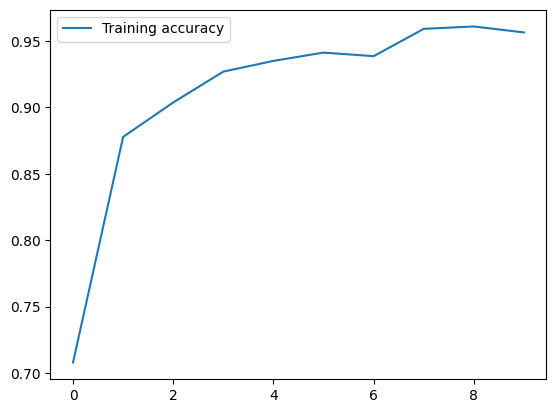

In [38]:
# Plot Accuracy
plt.plot(results.history['accuracy'], label='Training accuracy')
plt.legend()

In [40]:
import numpy as np

# Sample predictions from a softmax output
y_predicted = model.predict(X_test)  # Softmax predictions

# Get the predicted class by finding the index of the maximum value along axis 1 (per row)
y_predicted_classes = np.argmax(y_predicted, axis=1)  # Resulting in class labels

# Check the predicted class labels
print("Predicted classes:", y_predicted_classes)

12/12 [==============================] - 4s 274ms/step
Predicted classes: [0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1
 1 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1
 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1
 1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 0 0 1
 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1
 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 1 1
 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1
 0 1 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1
 0 0 0 1]


In [42]:
X_test.head()

,v2
3291,Dear good morning how you feeling dear
3792,Hey are you angry with me. Reply me dr.
4407,Take care and sleep well.you need to learn to ...
941,Theyre doing it to lots of places. Only hospit...
5082,Amazing : If you rearrange these letters it gi...


In [43]:
# Loop through the first 20 samples
for i in range(20):
    sample_text = X_test.iloc[i]['v2'] # The original text for the sample
    prediction = y_predicted_classes[i]  # The predicted output (0 or 1)

    # Convert the prediction to a human-readable label
    if prediction == 0:
        label = "Not spam"
    elif prediction == 1:
        label = "Spam"

    # Display the sample text and its predicted output
    print(f"Sample {i+1}: '{sample_text}'")
    print(f"Prediction: {label} \n")


Sample 1: 'Dear good morning how you feeling dear'
Prediction: Not spam 

Sample 2: 'Hey are you angry with me. Reply me dr.'
Prediction: Not spam 

Sample 3: 'Take care and sleep well.you need to learn to change in life.you only need to get CONVINCED on that.i will wait but no more conversations between us.GET CONVINCED by that time.Your family is over for you in many senses.respect them but not overemphasise.or u have no role in my life.'
Prediction: Not spam 

Sample 4: 'Theyre doing it to lots of places. Only hospitals and medical places are safe.'
Prediction: Not spam 

Sample 5: 'Amazing : If you rearrange these letters it gives the same meaning... Dormitory = Dirty room Astronomer = Moon starer The eyes = They see Election results = Lies lets recount Mother-in-law = Woman Hitler Eleven plus two =Twelve plus one Its Amazing... !:-)'
Prediction: Not spam 

Sample 6: 'No 1 POLYPHONIC tone 4 ur mob every week! Just txt PT2 to 87575. 1st Tone FREE ! so get txtin now and tell ur frien

Confusion Matrix:
[[179   8]
 [  7 180]]


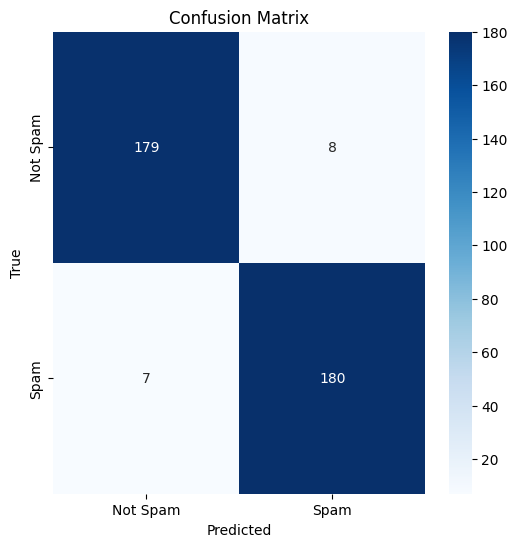

In [44]:
# Assuming softmax predictions from the model
y_predicted_classes = np.argmax(y_predicted, axis=1)  # Convert softmax predictions to class labels

# Converting one-hot labels to class labels
y_test_classes = np.argmax(y_test_one_hot, axis=1)  # From one-hot to class labels

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_predicted_classes)  # True vs. predicted classes

# Print the confusion matrix to see the raw data
print("Confusion Matrix:")
print(conf_matrix)

# Optional: Visualize the confusion matrix with a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
